In [207]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm
from collections import OrderedDict, Counter
import copy

In [208]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 962.07it/s]
Loading cached split indices for dataset at /home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [209]:
min_freq = 5
tokenizer = get_tokenizer("basic_english", language="en")

tokens = []
unk_token = "<unk>"
pad_token = "<pad>"
for text in tqdm(train_df['text'], total=len(train_df)):
    tokens += tokenizer(text)
vocabulary = vocab(OrderedDict(sorted(Counter(tokens).items(), key=lambda x: x[1], reverse=True)), min_freq=min_freq, specials=[pad_token, unk_token])
vocabulary.set_default_index(vocabulary[unk_token])

100%|██████████| 20000/20000 [00:01<00:00, 15754.43it/s]


In [210]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [00:03<00:00, 6648.98it/s]


In [211]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    n_samples = len(X)
    n_batches = n_samples // batch_size
    for i in range(n_batches):
        X_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        max_len = max([len(x) for x in X_batch])
        #print(max_len)
        #print(X_batch[0])
        X_batch = torch.stack(
            [torch.cat((torch.tensor([pad_id] * (max_len - len(x)), dtype=int), x)) for x in X_batch],
        )
        yield X_batch, torch.tensor(y_batch, dtype=torch.int)

train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

print(next(train_gen()))

(tensor([[   0,    0,    0,  ...,   57,   35,    3],
        [   0,    0,    0,  ...,    1,    9,    3],
        [   0,    0,    0,  ...,  131,  180,    3],
        ...,
        [   0,    0,    0,  ...,   34, 1525,    3],
        [   0,    0,    0,  ...,   14,   21,    3],
        [   0,    0,    0,  ...,   14,   23,   36]]), tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1], dtype=torch.int32))


In [212]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [213]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [214]:
# compute accuracy
def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    """
    Compute the accuracy of a model.
    Args:
        y_pred: the predictions of the model.
        y_true: the true labels.
    Returns:
        The accuracy of the model.
    """
    with torch.no_grad():
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        return (y_pred == y_true).sum().item() / len(y_true)


## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [215]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    return_train_loss = []
    return_valid_loss = []
    best_model = None
    best_valid_loss = np.inf

    for epochs in range(n_epochs):
        model.train()
        train_loss_l = []
        train_acc_l = []
        for X_batch, y_batch in tqdm(train_gen()):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze().float(), y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss_l.append(loss.item())
            train_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
        train_loss = np.mean(train_loss_l)
        train_acc = np.mean(train_acc_l)

        print(f"Epoch {epochs}/{n_epochs}")
        print(f"Train loss: {train_loss:.2E}, Train acc: {train_acc}")

        model.eval()
        valid_loss_l = []
        valid_acc_l = []
        with torch.no_grad():
            for X_batch, y_batch in tqdm(valid_gen()):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze().float(), y_batch.float())
                valid_loss_l.append(loss.item())
                valid_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
            valid_loss = np.mean(valid_loss_l)
            valid_acc = np.mean(valid_acc_l)

        print(f"Valid loss: {valid_loss:.2E}, Valid acc: {valid_acc}")

        return_train_loss.append(train_loss)
        return_valid_loss.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
        
    return best_model, return_train_loss, return_valid_loss

In [216]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [217]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

625it [00:03, 167.80it/s]


Epoch 0/20
Train loss: 6.80E-01, Train acc: 0.55865


156it [00:00, 397.23it/s]


Valid loss: 6.45E-01, Valid acc: 0.6235977564102564


625it [00:03, 168.82it/s]


Epoch 1/20
Train loss: 6.37E-01, Train acc: 0.63615


156it [00:00, 395.44it/s]


Valid loss: 6.78E-01, Valid acc: 0.5472756410256411


625it [00:03, 168.75it/s]


Epoch 2/20
Train loss: 6.12E-01, Train acc: 0.6618


156it [00:00, 386.18it/s]


Valid loss: 5.86E-01, Valid acc: 0.703926282051282


625it [00:03, 172.13it/s]


Epoch 3/20
Train loss: 5.38E-01, Train acc: 0.7334


156it [00:00, 388.25it/s]


Valid loss: 6.38E-01, Valid acc: 0.6191907051282052


625it [00:03, 169.35it/s]


Epoch 4/20
Train loss: 5.00E-01, Train acc: 0.75885


156it [00:00, 394.06it/s]


Valid loss: 5.74E-01, Valid acc: 0.7139423076923077


625it [00:03, 170.27it/s]


Epoch 5/20
Train loss: 4.81E-01, Train acc: 0.7815


156it [00:00, 389.63it/s]


Valid loss: 5.43E-01, Valid acc: 0.7598157051282052


625it [00:03, 168.95it/s]


Epoch 6/20
Train loss: 4.15E-01, Train acc: 0.8258


156it [00:00, 400.21it/s]


Valid loss: 5.03E-01, Valid acc: 0.7744391025641025


625it [00:03, 168.34it/s]


Epoch 7/20
Train loss: 4.99E-01, Train acc: 0.75895


156it [00:00, 377.95it/s]


Valid loss: 5.27E-01, Valid acc: 0.7602163461538461


625it [00:03, 168.46it/s]


Epoch 8/20
Train loss: 5.36E-01, Train acc: 0.729


156it [00:00, 372.79it/s]


Valid loss: 5.77E-01, Valid acc: 0.7143429487179487


625it [00:03, 169.23it/s]


Epoch 9/20
Train loss: 4.38E-01, Train acc: 0.8031


156it [00:00, 374.38it/s]


Valid loss: 6.01E-01, Valid acc: 0.6864983974358975


625it [00:03, 169.47it/s]


Epoch 10/20
Train loss: 5.06E-01, Train acc: 0.7414


156it [00:00, 396.04it/s]


Valid loss: 6.71E-01, Valid acc: 0.5534855769230769


625it [00:03, 169.90it/s]


Epoch 11/20
Train loss: 6.20E-01, Train acc: 0.64275


156it [00:00, 385.49it/s]


Valid loss: 6.38E-01, Valid acc: 0.6195913461538461


625it [00:03, 169.42it/s]


Epoch 12/20
Train loss: 5.27E-01, Train acc: 0.7305


156it [00:00, 365.28it/s]


Valid loss: 5.82E-01, Valid acc: 0.7093349358974359


625it [00:03, 169.24it/s]


Epoch 13/20
Train loss: 4.50E-01, Train acc: 0.79395


156it [00:00, 389.10it/s]


Valid loss: 6.10E-01, Valid acc: 0.7163461538461539


625it [00:03, 169.48it/s]


Epoch 14/20
Train loss: 3.93E-01, Train acc: 0.83495


156it [00:00, 396.01it/s]


Valid loss: 5.54E-01, Valid acc: 0.7439903846153846


625it [00:03, 170.05it/s]


Epoch 15/20
Train loss: 3.51E-01, Train acc: 0.8536


156it [00:00, 379.68it/s]


Valid loss: 5.57E-01, Valid acc: 0.7403846153846154


625it [00:03, 169.99it/s]


Epoch 16/20
Train loss: 5.46E-01, Train acc: 0.7273


156it [00:00, 394.03it/s]


Valid loss: 6.26E-01, Valid acc: 0.6262019230769231


625it [00:03, 169.73it/s]


Epoch 17/20
Train loss: 4.68E-01, Train acc: 0.7743


156it [00:00, 388.24it/s]


Valid loss: 5.60E-01, Valid acc: 0.7205528846153846


625it [00:03, 171.05it/s]


Epoch 18/20
Train loss: 3.51E-01, Train acc: 0.85365


156it [00:00, 384.44it/s]


Valid loss: 5.48E-01, Valid acc: 0.7449919871794872


625it [00:03, 169.71it/s]


Epoch 19/20
Train loss: 3.80E-01, Train acc: 0.83715


156it [00:00, 393.84it/s]

Valid loss: 5.42E-01, Valid acc: 0.7481971153846154


[0.6795486579895019, 0.6365214299201966, 0.6119391561031342, 0.537736960029602, 0.4999288324832916, 0.4807559734582901, 0.41466518270969394, 0.4990283653497696, 0.5357163755893707, 0.4382558817386627, 0.5058464178800582, 0.6204892938137054, 0.5265603261232377, 0.45042432079315187, 0.3932820630788803, 0.351499772465229, 0.5456798352956772, 0.46764817891120913, 0.3514396258831024, 0.3801278445959091]


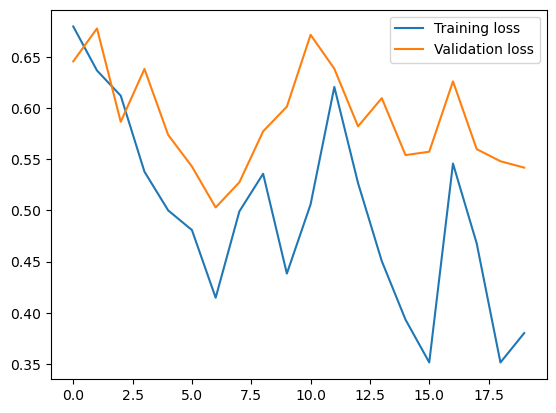

In [218]:
import matplotlib.pyplot as plt
print(train_losses)
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [221]:
# print the test, train and validation accuracy
def test(model: nn.Module, test_gen: Callable) -> float:
    """Test a model.
    Args:
        model: a class inheriting from nn.Module.
        test_gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    test_acc_l = []
    with torch.no_grad():
        for X_batch, y_batch in test_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            test_acc_l.append(accuracy(y_pred.squeeze().float(), y_batch.float()))
        test_acc = np.mean(test_acc_l)
    return test_acc

print(f"Test accuracy: {test(best_model, test_gen)}")
print(f"Train accuracy: {test(best_model, train_gen)}")
print(f"Valid accuracy: {test(best_model, valid_gen)}")

Test accuracy: 0.7764484635083226
Train accuracy: 0.8512
Valid accuracy: 0.7744391025641025
